# Camera Calibration

* https://docs.opencv.org/master/d6/d55/tutorial_table_of_content_calib3d.html
* https://www.mathworks.com/help/vision/ug/camera-calibration.html
* http://www.vision.caltech.edu/bouguetj/calib_doc/htmls/parameters.html

<!--NAVIGATION-->

<a href="https://colab.research.google.com/github/yongduek/cvip//blob/master/camera_calib.ipynb"><img align="left" src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open in Colab" title="Open and Execute in Google Colaboratory"></a>


In [1]:
%matplotlib inline
import matplotlib as mpl
mpl.rcParams['figure.figsize'] = (10,5)
import matplotlib.pyplot as plt
import numpy as np
import cv2 as cv

## Create Calibration Pattern
* https://docs.opencv.org/master/d6/d55/tutorial_table_of_content_calib3d.html

Now, if you want to create your own pattern, you will need python to use https://github.com/opencv/opencv/blob/master/doc/pattern_tools/gen_pattern.py

```    
python gen_pattern.py -o chessboard.svg --rows 9 --columns 6 --type checkerboard --square_size 20


python gen_pattern.py -o circleboard.svg --rows 7 --columns 5 --type circles --square_size 15
 
python gen_pattern.py -o acircleboard.svg --rows 7 --columns 5 --type acircles --square_size 10 --radius_rate 2
```

In [2]:
# run the script to get an svg image file
!python3 opencv-doc/pattern_tools/gen_pattern.py -o chessboard.svg --rows 9 --columns 6 --type checkerboard --square_size 20

python3: can't open file 'opencv-doc/pattern_tools/gen_pattern.py': [Errno 2] No such file or directory


In [3]:
from svglib.svglib import svg2rlg
from reportlab.graphics import renderPDF, renderPM
drawing = svg2rlg('chessboard.svg')
renderPDF.drawToFile (drawing, 'chesspoard.pdf')

---
## Camera Calibration
---
- https://docs.opencv.org/2.4/modules/calib3d/doc/camera_calibration_and_3d_reconstruction.html

The functions in this section use a so-called pinhole camera model. In this model, a scene view is formed by projecting 3D points into the image plane using a perspective transformation.

<img src="https://github.com/yongduek/cvip/blob/master/camcal/1.png?raw=1">
<img src="https://github.com/yongduek/cvip/blob/master/camcal/2.png?raw=1">

Thus, if an image from the camera is scaled by a factor, all of these parameters should be scaled (multiplied/divided, respectively) by the same factor. The matrix of intrinsic parameters does not depend on the scene viewed. So, once estimated, it can be re-used as long as the focal length is fixed (in case of zoom lens). The joint rotation-translation matrix [R|t] is called a matrix of extrinsic parameters. It is used to describe the camera motion around a static scene, or vice versa, rigid motion of an object in front of a still camera. That is, [R|t] translates coordinates of a point (X, Y, Z) to a coordinate system, fixed with respect to the camera. The transformation above is equivalent to the following (when z \ne 0 ):

<img src="https://github.com/yongduek/cvip/blob/master/camcal/3.png?raw=1">

**Pin-hole Camera Model**

<img src="https://github.com/yongduek/cvip/blob/master/camcal/pinhole_camera_model.png?raw=1">

Real lenses usually have some distortion, mostly radial distortion and slight tangential distortion. So, the above model is extended as:

<img src="https://github.com/yongduek/cvip/blob/master/camcal/4.png?raw=1">

The next figure shows two common types of radial distortion: barrel distortion (typically $k_1 > 0$ and pincushion distortion (typically $k_1 < 0$).

<img src="https://github.com/yongduek/cvip/blob/master/camcal/5.png?raw=1">

default distort_parameters = $[k_1, k_2, p_1, p_2, k_3]$

### First, set the size of the pattern and its corresponding World coordinates

In [4]:
import glob
# termination criteria
criteria = (cv.TERM_CRITERIA_EPS + cv.TERM_CRITERIA_MAX_ITER, 30, 0.001)

# prepare object points, like (0,0,0), (1,0,0), (2,0,0) ....,(6,5,0) ...
patternSize = (9,6)
objp = np.zeros((patternSize[0]*patternSize[1],3), np.float32)
objp[:,:2] = np.mgrid[0:patternSize[0],0:patternSize[1]].T.reshape(-1,2)
print (objp[0:10])

[[0. 0. 0.]
 [1. 0. 0.]
 [2. 0. 0.]
 [3. 0. 0.]
 [4. 0. 0.]
 [5. 0. 0.]
 [6. 0. 0.]
 [7. 0. 0.]
 [8. 0. 0.]
 [0. 1. 0.]]


### Image detection of the chessboard corners.

In [5]:
import sys, os
dirname = './opencv_samples_data'
try:
    os.makedirs(dirname)
    
except:
    pass
cmd = os.listdir(dirname)
print (cmd)


['20191113_162607.jpg', '20191113_162621.jpg', '20191113_162554.jpg', '20191113_162604.jpg', '20191113_162619.jpg', '20191113_162610.jpg', '20191113_162557.jpg', '20191113_162605.jpg', '20191113_162614.jpg', '20191113_162552.jpg', '20191113_162559.jpg', '20191113_162602.jpg']


In [6]:
import glob
#imagefiles = sorted(glob.glob('opencv_samples_data/20191113_1528??.jpg'))
imagefiles = sorted(glob.glob('opencv_samples_data/20191113_1625??.jpg'))

for i,fname in enumerate(imagefiles):
    img=cv.imread(fname,cv.IMREAD_UNCHANGED)
    #cv2.imread('/home/img/python.png', cv2.IMREAD_UNCHANGED)

    print(fname)
    try:
        resized = cv.resize(img, (720,480), interpolation = cv.INTER_AREA)
    except Exception as e:
        print(str(e))
    outfname = f'./opencv_samples_data/calib-pattern-res-{i:02d}.png'
    print(outfname)
    cv.imwrite(outfname,resized)

opencv_samples_data/20191113_162552.jpg
./opencv_samples_data/calib-pattern-res-00.png
opencv_samples_data/20191113_162554.jpg
./opencv_samples_data/calib-pattern-res-01.png
opencv_samples_data/20191113_162557.jpg
./opencv_samples_data/calib-pattern-res-02.png
opencv_samples_data/20191113_162559.jpg
./opencv_samples_data/calib-pattern-res-03.png


In [7]:
import glob
#imagefiles = sorted(glob.glob('opencv_samples_data/20191113_1528??.jpg'))
imagefiles = sorted(glob.glob('opencv_samples_data/calib-pattern-res-??.png'))
imagefiles

['opencv_samples_data/calib-pattern-res-00.png',
 'opencv_samples_data/calib-pattern-res-01.png',
 'opencv_samples_data/calib-pattern-res-02.png',
 'opencv_samples_data/calib-pattern-res-03.png']

In [8]:
# Arrays to store object points and image points from all the images.
objpoints = [] # 3d point in real world space
imgpoints = [] # 2d points in image plane.
for i, fname in enumerate(imagefiles):
    print ('processing: ', fname)
    img = cv.imread(fname)
    if img is None:
        continue
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    #cv.imshow('gray',gray)
    #cv.waitKey(500)
    # Find the chess board corners
    ret, corners = cv.findChessboardCorners(gray, patternSize=patternSize)
    # If found, add object points, image points (after refining them)
    if ret == True:
        objpoints.append(objp)
        corners2 = cv.cornerSubPix(gray, corners, (11,11), (-1,-1), criteria)
        imgpoints.append(corners2)
        # Draw and display the corners
        cv.drawChessboardCorners(img, patternSize=patternSize, corners=corners2, patternWasFound=ret)
        cv.imshow('img', img)
        outfname = f'results/calib-pattern-res-{i:02d}.png'
        cv.imwrite(outfname, img)
        print ('   --> ', outfname)
        cv.waitKey(500)
    else:
        print ('   --> skip.')
cv.destroyAllWindows()

processing:  opencv_samples_data/calib-pattern-res-00.png
   --> skip.
processing:  opencv_samples_data/calib-pattern-res-01.png
   --> skip.
processing:  opencv_samples_data/calib-pattern-res-02.png
   --> skip.
processing:  opencv_samples_data/calib-pattern-res-03.png
   --> skip.


In [59]:
ip = imgpoints[-1].copy()
print(ip.shape)
ip = ip.reshape(ip.shape[0], ip.shape[2])
print(ip.shape, ip[0])

IndexError: list index out of range

### Let's see the image locations of the world orgin, x-axis, and y-axis points.

NameError: name 'ip' is not defined

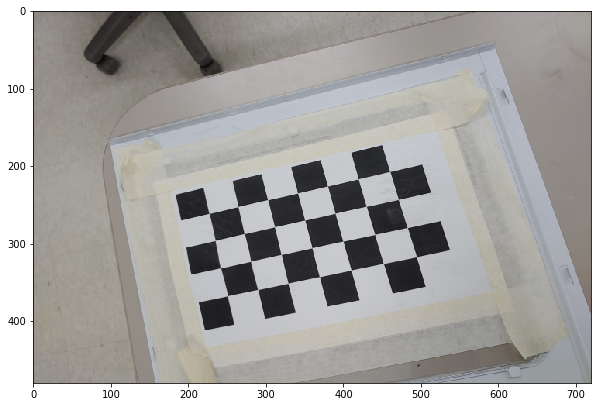

In [58]:
plt.figure(figsize=(10,7))
plt.imshow (img[:,:,::-1]) # BGR -> RGB for plt.imshow()
i = 0 # The world origin
plt.scatter(ip[i,0], ip[i,1], marker='*', color='r', s=350, alpha=0.7)
# The end tip of x-axis
i = patternSize[0] - 1  
plt.scatter(ip[i,0], ip[i,1], marker='o', color='r', s=350, alpha=0.7)
# the end tip of y-axis
i = patternSize[0] * (patternSize[1]-1) 
plt.scatter(ip[i,0], ip[i,1], marker='s', color='r', s=350, alpha=0.7)

Now we can see that the z-axis of the world goes down towards the person from the origin.

### Calibration
Now that we have our object points and image points, we are ready to go for calibration. We can use the function, `cv.calibrateCamera()` which returns the camera matrix, distortion coefficients, rotation and translation vectors etc. 

In [14]:
ret, Kmat, distCoeff, rvecs, tvecs = cv.calibrateCamera(objpoints, 
                                                  imgpoints, 
                                                  imageSize=gray.shape[::-1], 
                                                  cameraMatrix=None, distCoeffs=None)

In [15]:
Kmat

array([[536.07343678,   0.        , 342.37038243],
       [  0.        , 536.01635208, 235.53685416],
       [  0.        ,   0.        ,   1.        ]])

In [16]:
distCoeff

array([[-0.26509011, -0.04674355,  0.00183301, -0.00031471,  0.25231509]])

In [17]:
rvecs[:2]

[array([[0.16853568],
        [0.27575315],
        [0.01346807]]), array([[ 0.41306754],
        [ 0.64934522],
        [-1.33719481]])]

In [18]:
tvecs[:2]

[array([[-3.01118527],
        [-4.3575667 ],
        [15.99287311]]), array([[-2.34551346],
        [ 3.31931524],
        [14.15396047]])]

### Re-projection Test

In [19]:
proj, _ = cv.projectPoints(objpoints[-1], rvecs[-1], tvecs[-1], Kmat, distCoeff)
proj.shape

(54, 1, 2)

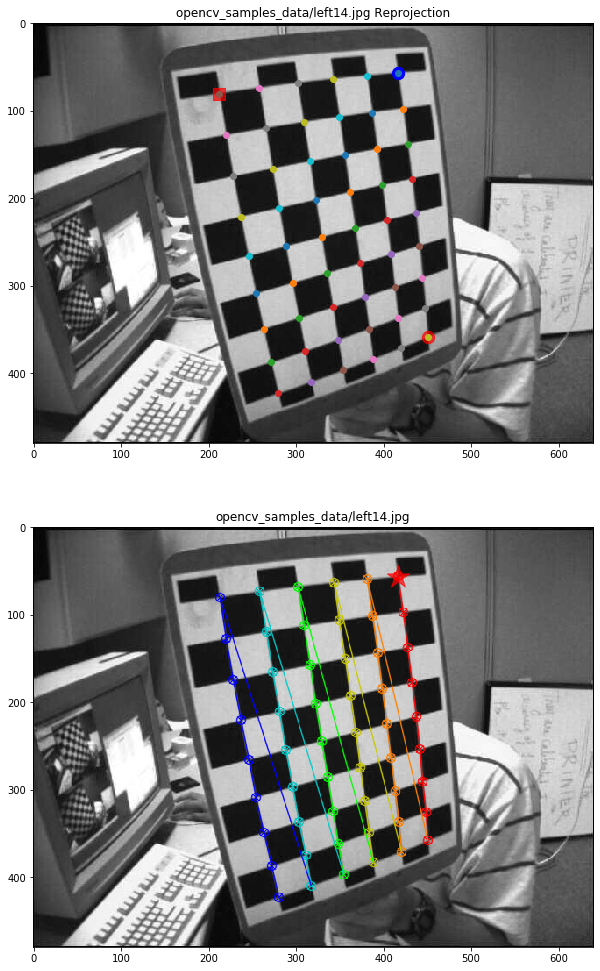

In [20]:
fig, ax = plt.subplots(2,1, figsize=(15,17))

simg = cv.imread(imagefiles[-1])   # read image
ax[0].imshow(simg[:,:,::-1])       # show
ax[0].set_title(imagefiles[-1] + ' Reprojection')
i = 0 # The origin point
ax[0].scatter(proj[0,0,0], proj[0,0,1], marker='o', color='b', s=150)  # projection of the origin
i = patternSize[0] - 1  # The end of the x-axis
ax[0].scatter(proj[i,0,0], proj[i,0,1], marker='o', color='r', s=150, alpha=0.7) # projection of x-axis
# the end tip of y-axis
i = patternSize[0] * (patternSize[1]-1) 
ax[0].scatter(proj[i,0,0], proj[i,0,1], marker='s', color='r', s=150, alpha=0.7) # projection of y-axis
#

pp = proj.reshape(-1, 2)    # other points
for xy in pp:
    ax[0].scatter(xy[0], xy[1])

# Second image Show
ax[1].set_title(imagefiles[-1])
ax[1].imshow(img[:,:,::-1])
i = 0 # The world origin
ax[1].scatter(ip[i,0], ip[i,1], marker='*', color='r', s=550, alpha=0.7)

### Reprojection Step-by-step

In [21]:
X3dW = objpoints[0].T
X3dW.shape

(3, 54)

In [22]:
X3dW[:,:7]

array([[0., 1., 2., 3., 4., 5., 6.],
       [0., 0., 0., 0., 0., 0., 0.],
       [0., 0., 0., 0., 0., 0., 0.]], dtype=float32)

**Rotation**

Conversion of rvec to R mat:

<img src="https://github.com/yongduek/cvip/blob/master/camcal/rodrigues_eq.png?raw=1">

In [23]:
# we consider the last view
Rmat, _ = cv.Rodrigues(rvecs[-1])
Rmat

array([[ 0.14628383, -0.89499702, -0.42140406],
       [ 0.96235226,  0.22739732, -0.1488912 ],
       [ 0.22908333, -0.38375877,  0.89456695]])

In [24]:
Xc = Rmat @ X3dW
Xc[:,:4]

array([[0.        , 0.14628383, 0.29256766, 0.43885148],
       [0.        , 0.96235226, 1.92470452, 2.88705677],
       [0.        , 0.22908333, 0.45816666, 0.68724999]])

**Translation**

In [25]:
print ('translation vector:\n', tvecs[-1], tvecs[-1].shape)

translation vector:
 [[ 1.79855747]
 [-4.32644219]
 [12.50141687]] (3, 1)


In [26]:
Xc = Xc + tvecs[-1]
Xc[:,:4]

array([[ 1.79855747,  1.9448413 ,  2.09112513,  2.23740896],
       [-4.32644219, -3.36408993, -2.40173767, -1.43938541],
       [12.50141687, 12.7305002 , 12.95958353, 13.18866687]])

**Projection**

In [27]:
zc = Xc[2,:]
Xc = Xc / zc # [x/z, y/z, 1]
Xc[:, :4]

array([[ 0.14386829,  0.15277022,  0.16135743,  0.16964633],
       [-0.34607615, -0.26425434, -0.18532522, -0.10913805],
       [ 1.        ,  1.        ,  1.        ,  1.        ]])

**Lens distortion**

<img src="https://github.com/yongduek/cvip/blob/master/camcal/4.png?raw=1">

distCoeff =  $[k_1, k_2, p_1, p_2, k_3]$

In [28]:
distCoeff 

array([[-0.26509011, -0.04674355,  0.00183301, -0.00031471,  0.25231509]])

In [29]:
def lens_distort(xyarr, dc):
    distorted = xyarr.copy()
    k1,k2,p1,p2,k3 = dc
    for dxy, xy in zip(distorted.T, xyarr.T):
        #print (xy, "--")
        r2 = xy[0]**2 + xy[1]**2
        radial = (1 + k1*r2 + k2*np.power(r2,2) + k3*np.power(r2,3)) #
        dxy[0] = xy[0] * radial + 2*p1*xy[0]*xy[1] + p2*(r2 + 2*xy[0]**2)
        dxy[1] = xy[1] * radial + p1*(r2 + 2*xy[1]**2) + 2*p2*xy[0]*xy[1]
        
    #
    return distorted
#

Xdistorted = lens_distort(Xc, distCoeff[0])
Xdistorted[:,:4]

array([[ 0.13823931,  0.14877425,  0.1586111 ,  0.16770735],
       [-0.33238447, -0.25722224, -0.18208209, -0.10782431],
       [ 1.        ,  1.        ,  1.        ,  1.        ]])

**Image Scaling and Translation** : transform to pixel space

In [30]:
Ximg = Kmat @ Xdistorted
Ximg[:, :4]

array([[416.4768067 , 422.12430353, 427.39757854, 432.27383865],
       [ 57.37334281,  97.66152558, 137.93787441, 177.74126336],
       [  1.        ,   1.        ,   1.        ,   1.        ]])

#### Comparison

In [31]:
proj, _ = cv.projectPoints(objpoints[-1], rvecs[-1], tvecs[-1], Kmat, distCoeff)
proj = proj.reshape(-1,2).T
proj[:,:4]

array([[416.4768  , 422.1243  , 427.39758 , 432.27383 ],
       [ 57.373344,  97.66152 , 137.93788 , 177.74126 ]], dtype=float32)

In [32]:
myProj = Ximg[:2, :]
myProj[:,:4]

array([[416.4768067 , 422.12430353, 427.39757854, 432.27383865],
       [ 57.37334281,  97.66152558, 137.93787441, 177.74126336]])

In [33]:
dist = myProj - proj

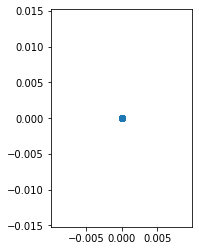

In [34]:
fig, ax = plt.subplots()
ax.scatter (dist[0,:], dist[1,:])
ax.set_aspect('equal')

Text(0.5, 1.0, 'distance between my projection and opencv-projection (in pixel unit)')

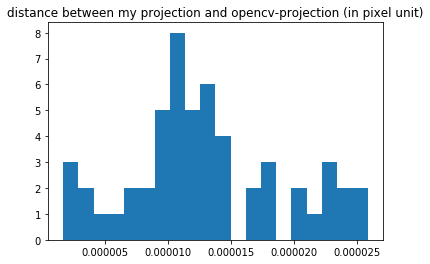

In [35]:
d_l2 = np.abs(dist[0]) + np.abs(dist[1])
plt.hist(d_l2, bins=20)
plt.title('distance between my projection and opencv-projection (in pixel unit)')

So our step-by-step projection gives the same output as cv.reprojection within the numerical computation error.

### Reprojection Error

In [0]:
# compute the total reprojection error
total_rms = 0
for i in range(len(objpoints)):
    proj, _ = cv.projectPoints(objpoints[i], rvecs[i], tvecs[i], Kmat, distCoeff)
    error = imgpoints[i] - proj
    error = error.reshape(-1,2).T
    
    e2 = error[0]**2 + error[1]**2
    e2 = e2.sum()
    total_rms += e2
#
total_rms = np.sqrt(total_rms / (len(objpoints) * objpoints[0].shape[0]))

print( "total rms: {:.2f} pixels".format(total_rms))

total rms: 0.41 pixels


### Undistorted Image Computation

Text(0.5, 1.0, 'An image of the calibration pattern. Lens distortion is visible.')

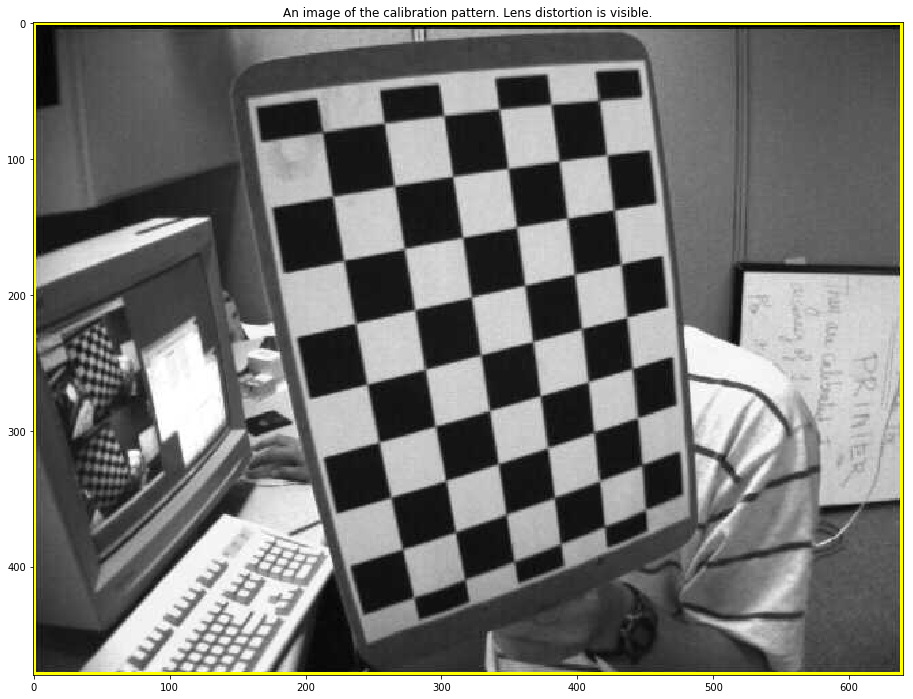

In [0]:
filename = 'left14-framed.png'
src = cv.imread(filename) # choose a file

plt.figure(figsize=(16, 12))
plt.imshow(src[:,:,::-1])
plt.title('An image of the calibration pattern. Lens distortion is visible.')

#### newKmat, validPixRoi = cv.getOptimalNewCameraMatrix()

The function computes and returns the optimal new camera matrix based on the free scaling parameter. 

By varying this parameter, you may retrieve 
1. only sensible pixels alpha=0
2. keep all the original image pixels if there is valuable information in the corners alpha=1 
3. or get something in between. When alpha>0

The undistortion result is likely to have some black pixels corresponding to “virtual” pixels outside of the captured distorted image. 

- **validPixROI** – Optional output rectangle that outlines all-good-pixels region in the undistorted image. (x, y, width, height)

In [0]:
h, w = src.shape[:2]
newKmat, roi = cv.getOptimalNewCameraMatrix (Kmat, distCoeff, imageSize=(w,h), alpha=1)
roi = np.array(roi)
roi

array([  4,  17, 625, 448])

In [0]:
newKmat

array([[469.4576416 ,   0.        , 341.9990285 ],
       [  0.        , 470.03912354, 236.70660423],
       [  0.        ,   0.        ,   1.        ]])

In [0]:
Kmat

array([[536.07343567,   0.        , 342.37038375],
       [  0.        , 536.01635124, 235.53685495],
       [  0.        ,   0.        ,   1.        ]])

**cv.undistort()**

In [0]:
undistorted = cv.undistort (src, Kmat, distCoeff, None, newKmat)
undistorted.shape
cv.imwrite("undistorted.png", undistorted)

True

Valid ROI Rectangle. 

OpenCV somehow determines this rectangle as a valid ROI in the undistorted image. It seems like the maximum rectangle fit inslide the undistorted boundary as can be seen in the image.

It is the same rectangle as the one obtained with `alpha=0` in `cv.getOptimalNewCameraMatrix()`.

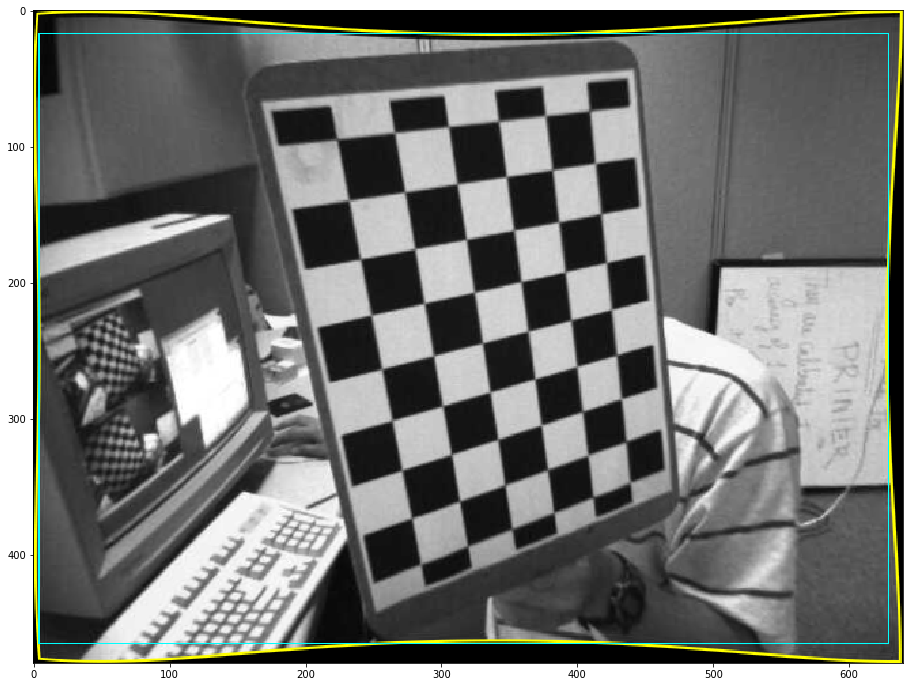

In [0]:
undistorted = cv.rectangle(undistorted, tuple(roi[:2]), tuple(roi[:2] + roi[2:]), (255,255,0), 1)
plt.figure(figsize=(16, 12))
plt.imshow(undistorted[:,:,::-1])

In [0]:
tuple(roi[:2])

(4, 17)

Text(0.5, 1.0, 'Undistorted Image')

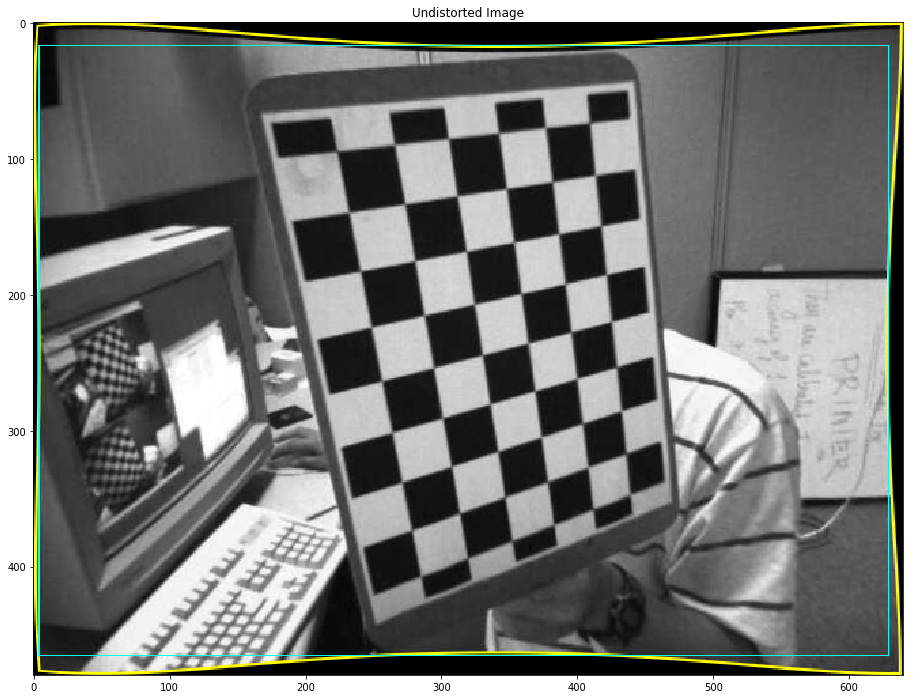

In [0]:
plt.figure(figsize=(16, 12))
plt.imshow(undistorted[:,:,::-1])
plt.title('Undistorted Image')

#### Pointwise undistortion

In [0]:
icorners = np.array([[[0.,0.]], [[0, w]], [[h, 0]], [[w,h]]])
un00 = cv.undistortPoints(icorners, Kmat, distCoeff, None, None, newKmat)
print (un00.reshape(-1,2), roi)

[[  2.31796083   1.86142712]
 [ 20.68809151 616.08642614]
 [473.11174962  11.81776107]
 [638.71429485 479.99996246]] (4, 17, 625, 448)


In [0]:
imgPun = cv.undistortPoints(imgpoints[-1], Kmat, distCoeff, None, None, newKmat)
imgPun = imgPun.reshape(-1,2)
imgP = imgpoints[-1].reshape(-1,2)

Text(0.5, 1.0, 'undistorted image and points: distCoef=[[-0.26509012 -0.04674346  0.00183301 -0.00031472  0.25231495]]')

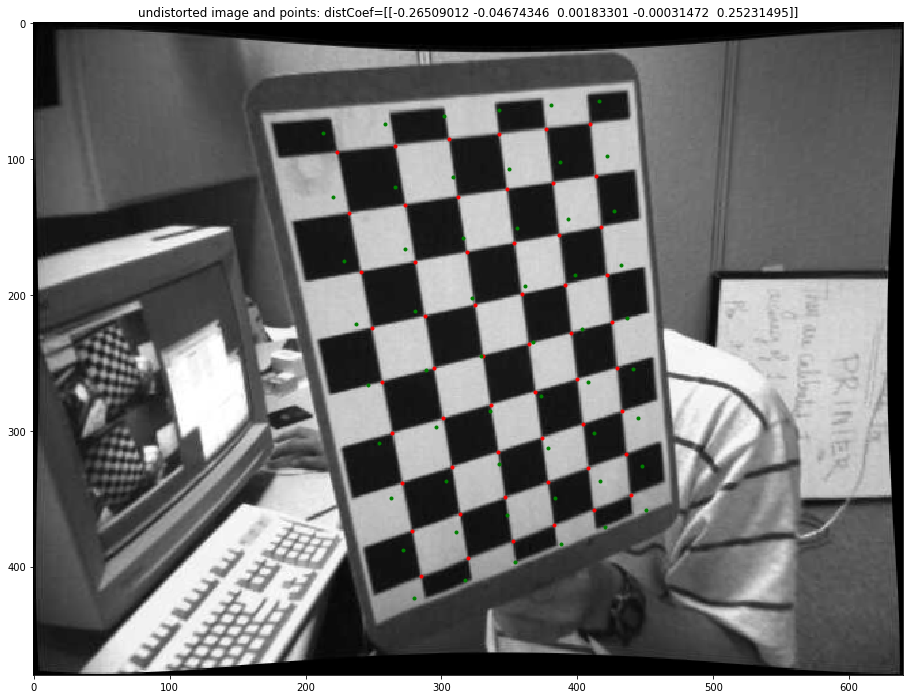

In [0]:
plt.figure(figsize=(16, 12))
plt.imshow(undistorted)
plt.scatter(imgPun[:,0], imgPun[:,1], c='r', marker='.') # undistorted points
plt.scatter(imgP[:,0], imgP[:,1], c='g', marker='.') # original points
plt.xticks(np.arange(0,img.shape[1],100))
plt.yticks(np.arange(0,img.shape[0],100))
plt.title ('undistorted image and points: distCoef={}'.format(distCoeff))

## Conclusion

Well, that's it.

When your camera seems to have lens distortion, then try to use this approach.

**Q. Take several photos of the calibration pattern and calibrate your phone's camera.**

# Camera Pose Estimation
- https://docs.opencv.org/master/d7/d53/tutorial_py_pose.html
- [Perspective n Point Algorithm](https://en.wikipedia.org/wiki/Perspective-n-Point)
- See the notebook for [Camera Pose Estimation PnP Algorithms](camera_pose_pnp.ipynb)

# Rolling Shutter or Global Shutter

- [A good example is given here](https://www.premiumbeat.com/blog/know-the-basics-of-global-shutter-vs-rolling-shutter/)

![Global vs Rolling Shutter](https://github.com/yongduek/cvip/blob/master/camcal/Global-Shutter-vs-Rolling-Shutter.jpg?raw=1)